In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from IPython.display import display

In [11]:
def remove_duplicate_labels():

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=4)

def get_parc_sizes(parc_dr):
    
    parcels = os.listdir(parc_dr)
    parc_sizes = {'freesurfer_destr': 150, 'freesurfer_desikan': 68}

    for p in parcels:
        parc = np.load(os.path.join(parc_dr, p))
        sz = len(np.unique(parc))
        name = p.replace('.npy', '')
        parc_sizes[name] = sz

    return parc_sizes

def get_results(results_dr):

    results = {}
    incomplete_cnt = 0
    result_files = os.listdir(results_dr)

    for file in result_files:
        result = np.load(os.path.join(results_dr, file))
        name = file.replace('.npy', '')
        
        if len(result) > 1:
            results[name] = result
        else:
            incomplete_cnt += 1
            
    print('Found:', len(results), 'Incomplete:', incomplete_cnt)
            
    return results

def conv_to_df(results):
    
    parcels, models = [], []
    targets, scores = [], []
    stds, is_binary = [], []

    for result in results:

        split = result.split('---')
        parcels.append(split[0])
        models.append(split[1])
        targets.append(split[2])

        score = results[result]

        # If regression
        if len(score) == 2:
            scores.append(score[0][0])
            stds.append(score[0][1])
            is_binary.append(False)

        # If binary
        else:
            scores.append(score[1][0])
            stds.append(score[1][1])
            is_binary.append(True)

    df = pd.DataFrame()
    df['parcel'] = parcels
    df['model'] = models
    df['is_binary'] = is_binary
    df['target'] = targets
    df['score'] = scores
    df['std'] = stds
    
    df = df.set_index(['model', 'parcel']).sort_index()
    
    return df

def plot_score_by_n(scores, title, ylabel, xlim=1050):
    
    plt.figure(figsize=(12, 8))
    
    cmap = plt.get_cmap('viridis')
    
    for parcel in scores.index:

        if 'icosahedron' in parcel:
            color = cmap(0)
            alpha = 1
            label = 'Icosahedron'
            marker = 'p'

        elif 'random' in parcel:
            color = 'black'
            alpha = .5
            label = 'Random'
            marker = "+"
            
        elif 'freesurfer' in parcel:
            color = cmap(.4)
            alpha = 1
            label = 'Freesurfer Extracted'
            marker = "*"

        else:
            color = cmap(.8)
            alpha = .8
            label = 'Existing'
            marker = "o"

        n_parcels = parc_sizes[parcel]
        plt.scatter(n_parcels, scores.loc[parcel],
                    color=color, alpha=alpha,
                    label=label, marker=marker, s=100)
        
        plt.ylabel(ylabel, fontsize=16)
        plt.xlabel('Num. Parcels', fontsize=16)
        
        if xlim is not None:
            plt.xlim(0, xlim)
        
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.legend()
        remove_duplicate_labels()
        
        plt.title(title, fontsize=20)
        
    os.makedirs('Figures/', exist_ok=True)
    
    plt.savefig('Figures/' + title + '_' + ylabel + '_' + str(xlim) + '.png', dpi=500)
    plt.show()
    
def plot_scores(means, ylabel):
    
    #for model, name in zip(['elastic', 'lgbm', 'svm'],
    #                       ['Elastic-Net', 'SVM', 'LGBM']):
        
    for model, name in zip(['elastic'],
                           ['Elastic-Net']):
        
        plot_score_by_n(means.loc[model], name, ylabel, xlim=1050)
        #plot_score_by_n(means.loc[model], name, ylabel, xlim=None)
        
def mean_score(df):
    return df['score'].mean()

def mean_rank(df):
    return df['rank'].mean()

def max_rank(df):
    return df['rank'].max()

def min_rank(df):
    return df['rank'].min()

In [12]:
parc_sizes = get_parc_sizes('../parcels')
results = get_results('../Exp/results')

df = conv_to_df(results)
parcel_df = df.reset_index().set_index('parcel')

Found: 9530 Incomplete: 261


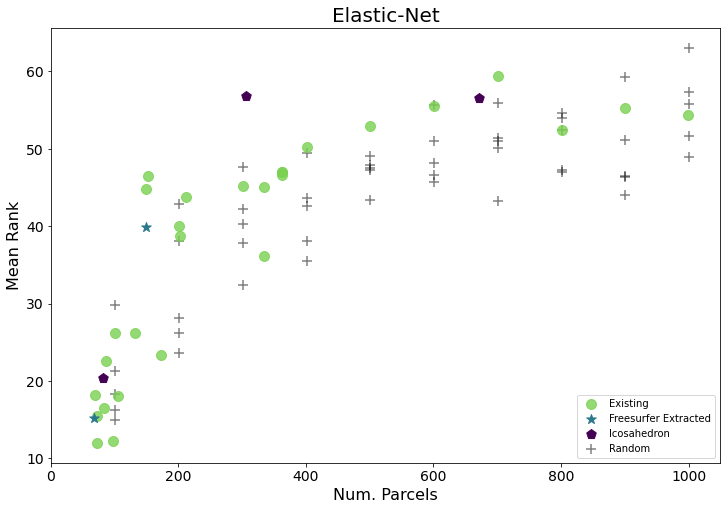

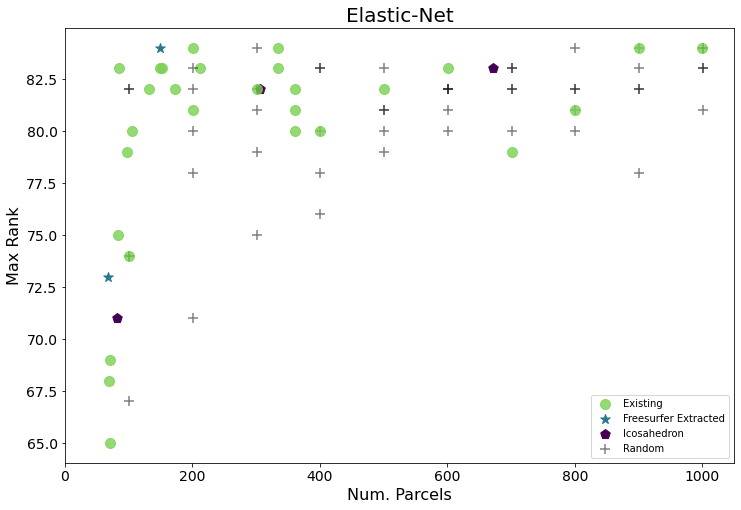

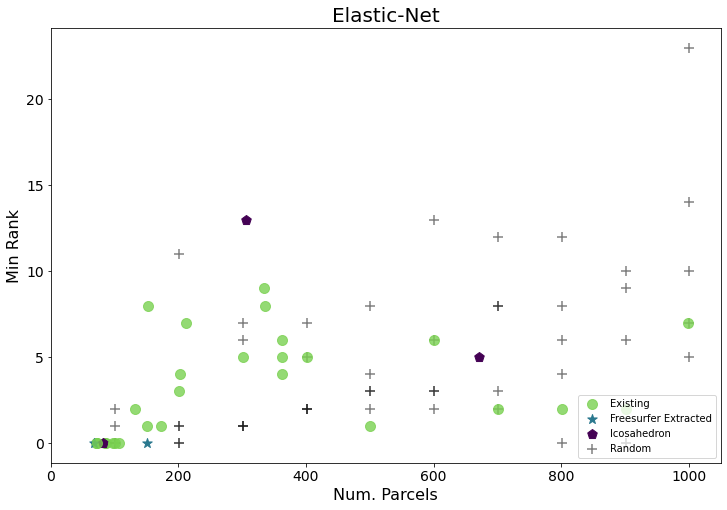

In [13]:
def get_rank_order(df):
    
    df = df.sort_values('score', ascending=True)
    df['rank'] = np.arange(0, len(df))
    return df['rank']

ranks = parcel_df.groupby(['model', 'target']).apply(get_rank_order)
ranks = ranks.to_frame().reset_index()

mean_ranks = ranks.groupby(['model', 'parcel']).apply(mean_rank)
max_ranks = ranks.groupby(['model', 'parcel']).apply(max_rank)
min_ranks = ranks.groupby(['model', 'parcel']).apply(min_rank)

plot_scores(mean_ranks, ylabel='Mean Rank')
plot_scores(max_ranks, ylabel='Max Rank')
plot_scores(min_ranks, ylabel='Min Rank')

In [14]:
split_means = df.groupby(['is_binary', 'model', 'parcel']).apply(mean_score)

regression_means = split_means.loc[False]
binary_means = split_means.loc[True]

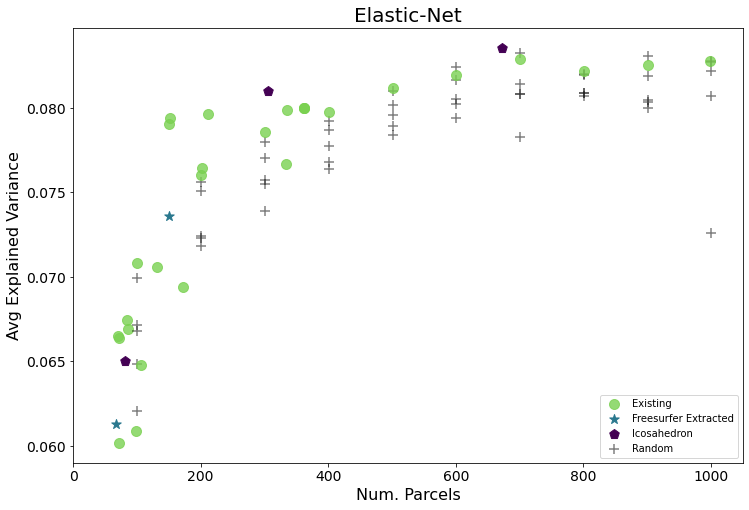

In [15]:
plot_scores(regression_means, ylabel='Avg Explained Variance')

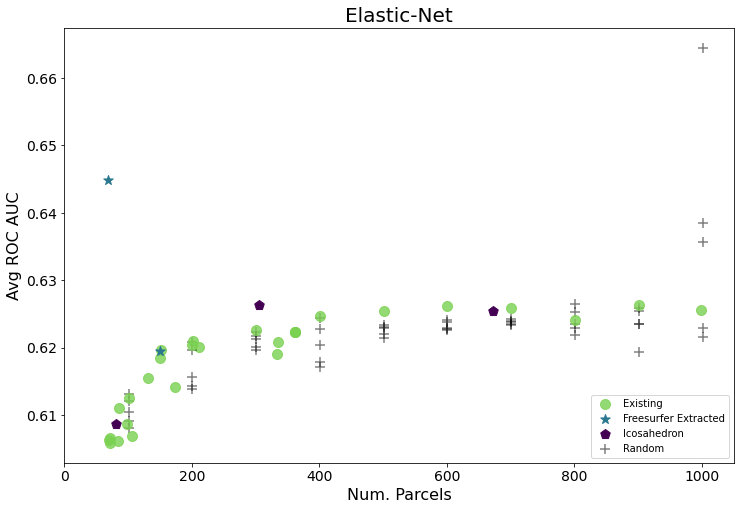

In [16]:
plot_scores(binary_means, ylabel='Avg ROC AUC')

In [17]:
for target in df.target.unique():
    display(df[df['target'] == target].loc['elastic'].sort_values('score', ascending=False).head(5))

,is_binary,target,score,std
parcel,,,,
schaefer_500,True,devhx_distress_at_birth_binary,0.589091,0.010937
gordon_abox,True,devhx_distress_at_birth_binary,0.584819,0.011791
random_800_1,True,devhx_distress_at_birth_binary,0.582871,0.007150
schaefer_400,True,devhx_distress_at_birth_binary,0.582813,0.018362
random_700_3,True,devhx_distress_at_birth_binary,0.582035,0.010420


,is_binary,target,score,std
parcel,,,,
random_1000_0,False,nihtbx_pattern_uncorrected,0.030294,0.004313
icosahedron-362_dlab,False,nihtbx_pattern_uncorrected,0.030163,0.003869
random_700_2,False,nihtbx_pattern_uncorrected,0.029806,0.003408
random_800_4,False,nihtbx_pattern_uncorrected,0.029174,0.002973
random_1000_2,False,nihtbx_pattern_uncorrected,0.028971,0.003905


,is_binary,target,score,std
parcel,,,,
schaefer_200,False,nihtbx_cardsort_uncorrected,0.047483,0.008676
random_200_3,False,nihtbx_cardsort_uncorrected,0.046984,0.006265
icosahedron-162_dlab,False,nihtbx_cardsort_uncorrected,0.046450,0.006272
schaefer_800,False,nihtbx_cardsort_uncorrected,0.046018,0.008097
icosahedron-642_dlab,False,nihtbx_cardsort_uncorrected,0.045906,0.010510


,is_binary,target,score,std
parcel,,,,
random_500_3,True,ksads_back_c_det_susp_p,0.686424,0.020144
power_abox,True,ksads_back_c_det_susp_p,0.685082,0.016048
destrieux_abox,True,ksads_back_c_det_susp_p,0.684783,0.035287
random_700_4,True,ksads_back_c_det_susp_p,0.684261,0.023803
icosahedron-362_dlab,True,ksads_back_c_det_susp_p,0.683599,0.032131


,is_binary,target,score,std
parcel,,,,
random_300_4,True,screentime_weekend_p_binary,0.590258,0.014257
random_1000_0,True,screentime_weekend_p_binary,0.589096,0.011993
brodmann,True,screentime_weekend_p_binary,0.589095,0.019266
random_300_0,True,screentime_weekend_p_binary,0.589044,0.018808
random_800_4,True,screentime_weekend_p_binary,0.587676,0.009337


,is_binary,target,score,std
parcel,,,,
random_1000_2,False,devhx_20_motor_dev_p,0.028130,0.009999
random_900_0,False,devhx_20_motor_dev_p,0.027756,0.008519
random_900_1,False,devhx_20_motor_dev_p,0.027414,0.010125
random_700_0,False,devhx_20_motor_dev_p,0.026681,0.007319
random_1000_1,False,devhx_20_motor_dev_p,0.026100,0.010783


,is_binary,target,score,std
parcel,,,,
random_100_3,True,prodrom_psych_ss_severity_score_binary,0.581434,0.008455
icosahedron-162_dlab,True,prodrom_psych_ss_severity_score_binary,0.580784,0.012314
random_200_1,True,prodrom_psych_ss_severity_score_binary,0.579145,0.008701
random_100_1,True,prodrom_psych_ss_severity_score_binary,0.579093,0.010768
random_200_3,True,prodrom_psych_ss_severity_score_binary,0.577107,0.012970


,is_binary,target,score,std
parcel,,,,
random_400_1,False,neurocog_pc3.bl,0.064456,0.008279
schaefer_300,False,neurocog_pc3.bl,0.060648,0.007981
glasser_2016_dlab,False,neurocog_pc3.bl,0.060474,0.011639
hcp_mmp,False,neurocog_pc3.bl,0.060474,0.011639
glasser_abox,False,neurocog_pc3.bl,0.060474,0.011639


,is_binary,target,score,std
parcel,,,,
schaefer_900,True,married.bl,0.698895,0.006439
random_1000_2,True,married.bl,0.698790,0.006981
random_400_4,True,married.bl,0.698199,0.005202
gordon_abox,True,married.bl,0.697074,0.006736
schaefer_800,True,married.bl,0.697067,0.005464


,is_binary,target,score,std
parcel,,,,
icosahedron-1002_dlab,False,devhx_2_birth_wt_lbs_p,0.307598,0.011753
icosahedron-642_dlab,False,devhx_2_birth_wt_lbs_p,0.307567,0.014782
icosahedron-362_dlab,False,devhx_2_birth_wt_lbs_p,0.302428,0.015163
schaefer_1000,False,devhx_2_birth_wt_lbs_p,0.299190,0.011568
schaefer_800,False,devhx_2_birth_wt_lbs_p,0.297680,0.015153


,is_binary,target,score,std
parcel,,,,
icosahedron-362_dlab,False,anthro_weight_calc,0.169366,0.010796
icosahedron-1002_dlab,False,anthro_weight_calc,0.167939,0.007793
icosahedron-642_dlab,False,anthro_weight_calc,0.166522,0.006708
schaefer_1000,False,anthro_weight_calc,0.164622,0.003773
schaefer_900,False,anthro_weight_calc,0.164530,0.006125


,is_binary,target,score,std
parcel,,,,
schaefer_1000,False,pea_wiscv_trs,0.059783,0.017013
destrieux_abox,False,pea_wiscv_trs,0.059701,0.014360
random_800_3,False,pea_wiscv_trs,0.059292,0.013695
random_700_4,False,pea_wiscv_trs,0.058892,0.017353
random_1000_0,False,pea_wiscv_trs,0.058574,0.014926


,is_binary,target,score,std
parcel,,,,
icosahedron-162_dlab,True,asr_scr_thought_r_binary,0.570378,0.019277
dextrieux_dlab,True,asr_scr_thought_r_binary,0.561844,0.020048
random_500_2,True,asr_scr_thought_r_binary,0.560599,0.021205
random_500_4,True,asr_scr_thought_r_binary,0.560567,0.015782
random_700_0,True,asr_scr_thought_r_binary,0.560009,0.019726


,is_binary,target,score,std
parcel,,,,
random_900_3,False,sports_activity_activities_p_performance,0.063779,0.010144
random_900_4,False,sports_activity_activities_p_performance,0.062749,0.009039
random_700_0,False,sports_activity_activities_p_performance,0.061545,0.009072
random_800_2,False,sports_activity_activities_p_performance,0.061262,0.008672
random_700_2,False,sports_activity_activities_p_performance,0.060709,0.006528


,is_binary,target,score,std
parcel,,,,
icosahedron-1002_dlab,False,anthro_height_calc,0.147548,0.010420
icosahedron-642_dlab,False,anthro_height_calc,0.142839,0.007355
random_1000_2,False,anthro_height_calc,0.140997,0.006584
random_500_3,False,anthro_height_calc,0.140421,0.012350
random_900_1,False,anthro_height_calc,0.138947,0.012605


,is_binary,target,score,std
parcel,,,,
random_300_4,False,neighb_phenx_ss_mean_p,0.056149,0.009253
random_400_4,False,neighb_phenx_ss_mean_p,0.055868,0.010548
icosahedron-162_dlab,False,neighb_phenx_ss_mean_p,0.055390,0.007757
schaefer_200,False,neighb_phenx_ss_mean_p,0.054983,0.008546
dextrieux_dlab,False,neighb_phenx_ss_mean_p,0.054811,0.009246


,is_binary,target,score,std
parcel,,,,
random_900_1,True,accult_phenx_q2_p,0.624101,0.019087
icosahedron-362_dlab,True,accult_phenx_q2_p,0.623933,0.018169
random_800_2,True,accult_phenx_q2_p,0.622889,0.019029
random_500_3,True,accult_phenx_q2_p,0.622637,0.021402
gordon,True,accult_phenx_q2_p,0.622597,0.018046


,is_binary,target,score,std
parcel,,,,
gordon_abox,False,sports_activity_activities_p_team_sport,0.072437,0.005016
gordon,False,sports_activity_activities_p_team_sport,0.072082,0.007697
random_300_0,False,sports_activity_activities_p_team_sport,0.071397,0.005758
shen_abox,False,sports_activity_activities_p_team_sport,0.069195,0.003922
schaefer_200,False,sports_activity_activities_p_team_sport,0.069023,0.007399


,is_binary,target,score,std
parcel,,,,
icosahedron-1002_dlab,True,devhx_5_twin_p,0.880119,0.010293
icosahedron-642_dlab,True,devhx_5_twin_p,0.874065,0.009098
schaefer_1000,True,devhx_5_twin_p,0.871106,0.012813
random_1000_2,True,devhx_5_twin_p,0.870984,0.006833
schaefer_800,True,devhx_5_twin_p,0.870914,0.011872


,is_binary,target,score,std
parcel,,,,
random_1000_4,True,ksads_adhd_composite_binary,0.575839,0.010299
random_600_2,True,ksads_adhd_composite_binary,0.574508,0.009422
schaefer_700,True,ksads_adhd_composite_binary,0.574483,0.011045
icosahedron-162_dlab,True,ksads_adhd_composite_binary,0.573835,0.007623
random_400_1,True,ksads_adhd_composite_binary,0.573651,0.007199


,is_binary,target,score,std
parcel,,,,
random_700_0,False,nihtbx_list_uncorrected,0.075633,0.010734
random_500_2,False,nihtbx_list_uncorrected,0.074401,0.008907
random_400_3,False,nihtbx_list_uncorrected,0.073792,0.010973
random_700_4,False,nihtbx_list_uncorrected,0.073453,0.010474
schaefer_700,False,nihtbx_list_uncorrected,0.073417,0.011155


,is_binary,target,score,std
parcel,,,,
random_1000_4,True,devhx_18_mnths_breast_fed_p_binary,0.641755,0.010563
schaefer_1000,True,devhx_18_mnths_breast_fed_p_binary,0.639960,0.009779
random_600_4,True,devhx_18_mnths_breast_fed_p_binary,0.638772,0.010111
random_400_2,True,devhx_18_mnths_breast_fed_p_binary,0.638705,0.012255
schaefer_700,True,devhx_18_mnths_breast_fed_p_binary,0.638586,0.010433


,is_binary,target,score,std
parcel,,,,
icosahedron-1002_dlab,True,sex_at_birth,0.957805,0.003034
icosahedron-642_dlab,True,sex_at_birth,0.954185,0.003294
random_1000_1,True,sex_at_birth,0.950293,0.004092
schaefer_1000,True,sex_at_birth,0.950114,0.002914
random_1000_0,True,sex_at_birth,0.949649,0.002915


,is_binary,target,score,std
parcel,,,,
random_600_3,True,devhx_ss_marijuana_amt_p_binary,0.635624,0.015722
freesurfer_destr,True,devhx_ss_marijuana_amt_p_binary,0.634777,0.026678
random_1000_0,True,devhx_ss_marijuana_amt_p_binary,0.631216,0.027872
icosahedron-642_dlab,True,devhx_ss_marijuana_amt_p_binary,0.630945,0.024312
shen_abox,True,devhx_ss_marijuana_amt_p_binary,0.630215,0.032882


,is_binary,target,score,std
parcel,,,,
schaefer_600,False,demo_prnt_age_p,0.070520,0.010510
random_800_0,False,demo_prnt_age_p,0.069222,0.012086
schaefer_500,False,demo_prnt_age_p,0.068495,0.008684
schaefer_400,False,demo_prnt_age_p,0.068081,0.011341
random_600_4,False,demo_prnt_age_p,0.067698,0.009339


,is_binary,target,score,std
parcel,,,,
random_400_1,True,devhx_ss_alcohol_avg_p_binary,0.583719,0.010374
freesurfer_destr,True,devhx_ss_alcohol_avg_p_binary,0.583453,0.009473
schaefer_700,True,devhx_ss_alcohol_avg_p_binary,0.582205,0.014082
schaefer_400,True,devhx_ss_alcohol_avg_p_binary,0.580671,0.023539
schaefer_900,True,devhx_ss_alcohol_avg_p_binary,0.580556,0.014491


,is_binary,target,score,std
parcel,,,,
random_100_1,True,ksads_bipolar_composite_binary,0.576849,0.017886
random_500_2,True,ksads_bipolar_composite_binary,0.576487,0.010904
random_400_3,True,ksads_bipolar_composite_binary,0.574882,0.010638
shen_abox,True,ksads_bipolar_composite_binary,0.574122,0.016208
power_abox,True,ksads_bipolar_composite_binary,0.572274,0.017351


,is_binary,target,score,std
parcel,,,,
schaefer_1000,False,anthro_waist_cm,0.102542,0.009080
fan_abox,False,anthro_waist_cm,0.101674,0.011919
schaefer_600,False,anthro_waist_cm,0.099956,0.009458
gordon_abox,False,anthro_waist_cm,0.099104,0.007955
random_800_2,False,anthro_waist_cm,0.099058,0.010054


,is_binary,target,score,std
parcel,,,,
schaefer_500,True,devhx_6_pregnancy_planned_p,0.658144,0.014342
schaefer_300,True,devhx_6_pregnancy_planned_p,0.657714,0.011181
random_800_3,True,devhx_6_pregnancy_planned_p,0.657694,0.009043
random_700_1,True,devhx_6_pregnancy_planned_p,0.656945,0.007147
schaefer_700,True,devhx_6_pregnancy_planned_p,0.656749,0.011839


,is_binary,target,score,std
parcel,,,,
schaefer_900,False,neurocog_pc1.bl,0.158005,0.014840
random_700_1,False,neurocog_pc1.bl,0.157716,0.018076
random_800_3,False,neurocog_pc1.bl,0.157082,0.018488
random_700_4,False,neurocog_pc1.bl,0.156868,0.019649
random_600_2,False,neurocog_pc1.bl,0.156210,0.020222


,is_binary,target,score,std
parcel,,,,
schaefer_1000,True,devhx_mother_probs_binary,0.572989,0.012037
random_600_4,True,devhx_mother_probs_binary,0.572527,0.012302
schaefer_800,True,devhx_mother_probs_binary,0.571981,0.010614
random_800_2,True,devhx_mother_probs_binary,0.571774,0.008955
random_900_2,True,devhx_mother_probs_binary,0.571185,0.009088


,is_binary,target,score,std
parcel,,,,
brodmann,False,interview_age,0.100880,0.015047
random_900_1,False,interview_age,0.097680,0.012347
random_800_2,False,interview_age,0.097216,0.013674
random_700_1,False,interview_age,0.097213,0.015655
icosahedron-642_dlab,False,interview_age,0.096974,0.015053


,is_binary,target,score,std
parcel,,,,
random_300_4,True,screentime_week_p_binary,0.610538,0.022996
baldassano_abox,True,screentime_week_p_binary,0.607822,0.023070
random_1000_2,True,screentime_week_p_binary,0.607717,0.020250
random_700_2,True,screentime_week_p_binary,0.607526,0.025784
random_600_1,True,screentime_week_p_binary,0.606643,0.022055


,is_binary,target,score,std
parcel,,,,
random_800_4,False,cbcl_scr_syn_rulebreak_r,0.022433,0.002487
dextrieux_dlab,False,cbcl_scr_syn_rulebreak_r,0.019896,0.006134
random_700_0,False,cbcl_scr_syn_rulebreak_r,0.019822,0.001635
random_700_1,False,cbcl_scr_syn_rulebreak_r,0.019810,0.001892
random_800_3,False,cbcl_scr_syn_rulebreak_r,0.019033,0.001165


,is_binary,target,score,std
parcel,,,,
random_1000_1,False,nihtbx_reading_uncorrected,0.077795,0.014022
random_700_4,False,nihtbx_reading_uncorrected,0.076850,0.013907
random_700_1,False,nihtbx_reading_uncorrected,0.075377,0.013837
random_600_1,False,nihtbx_reading_uncorrected,0.075303,0.012826
random_700_3,False,nihtbx_reading_uncorrected,0.075278,0.016045


,is_binary,target,score,std
parcel,,,,
icosahedron-642_dlab,True,devhx_12a_born_premature_p,0.762792,0.014475
icosahedron-1002_dlab,True,devhx_12a_born_premature_p,0.760907,0.015421
icosahedron-362_dlab,True,devhx_12a_born_premature_p,0.759296,0.016787
random_900_1,True,devhx_12a_born_premature_p,0.754098,0.018964
schaefer_700,True,devhx_12a_born_premature_p,0.753261,0.015328


,is_binary,target,score,std
parcel,,,,
freesurfer_destr,False,neurocog_pc2.bl,0.044753,0.012445
fan_abox,False,neurocog_pc2.bl,0.043217,0.009155
icosahedron-362_dlab,False,neurocog_pc2.bl,0.043174,0.006214
random_500_0,False,neurocog_pc2.bl,0.041334,0.007800
destrieux_abox,False,neurocog_pc2.bl,0.040654,0.011366


,is_binary,target,score,std
parcel,,,,
random_600_0,True,devhx_15_days_incubator_p_binary,0.690506,0.007427
random_500_0,True,devhx_15_days_incubator_p_binary,0.689545,0.005454
random_1000_2,True,devhx_15_days_incubator_p_binary,0.689541,0.004331
schaefer_1000,True,devhx_15_days_incubator_p_binary,0.688870,0.008513
schaefer_700,True,devhx_15_days_incubator_p_binary,0.688646,0.007075


,is_binary,target,score,std
parcel,,,,
brodmann,True,ksads_back_c_mh_sa_p,0.551409,0.010420
icosahedron-1002_dlab,True,ksads_back_c_mh_sa_p,0.550209,0.015746
random_200_3,True,ksads_back_c_mh_sa_p,0.550194,0.015866
schaefer_800,True,ksads_back_c_mh_sa_p,0.544738,0.009788
random_300_2,True,ksads_back_c_mh_sa_p,0.544089,0.012543


,is_binary,target,score,std
parcel,,,,
random_200_1,True,sleep_ss_total_p_binary,0.535325,0.004250
random_900_1,True,sleep_ss_total_p_binary,0.533764,0.011720
vdg11b,True,sleep_ss_total_p_binary,0.531720,0.006376
random_800_2,True,sleep_ss_total_p_binary,0.531221,0.012533
random_200_0,True,sleep_ss_total_p_binary,0.530516,0.015051


,is_binary,target,score,std
parcel,,,,
random_1000_1,False,nihtbx_picvocab_uncorrected,0.136758,0.012235
icosahedron-642_dlab,False,nihtbx_picvocab_uncorrected,0.134141,0.012329
random_1000_2,False,nihtbx_picvocab_uncorrected,0.133865,0.013142
schaefer_500,False,nihtbx_picvocab_uncorrected,0.133457,0.013941
schaefer_800,False,nihtbx_picvocab_uncorrected,0.132557,0.012434


,is_binary,target,score,std
parcel,,,,
random_100_1,True,cbcl_scr_syn_aggressive_r_binary,0.552270,0.019080
random_700_2,True,cbcl_scr_syn_aggressive_r_binary,0.551157,0.006327
random_200_4,True,cbcl_scr_syn_aggressive_r_binary,0.550048,0.016636
yeo_abox,True,cbcl_scr_syn_aggressive_r_binary,0.549580,0.006072
freesurfer_destr,True,cbcl_scr_syn_aggressive_r_binary,0.549559,0.013302


,is_binary,target,score,std
parcel,,,,
icosahedron-642_dlab,True,ksads_OCD_composite_binary,0.546828,0.014914
random_300_3,True,ksads_OCD_composite_binary,0.545325,0.021937
random_500_1,True,ksads_OCD_composite_binary,0.542974,0.019128
random_300_2,True,ksads_OCD_composite_binary,0.542489,0.009196
schaefer_600,True,ksads_OCD_composite_binary,0.542248,0.013165


,is_binary,target,score,std
parcel,,,,
dextrieux_dlab,False,lmt_scr_perc_correct,0.054365,0.006053
glasser_2016_dlab,False,lmt_scr_perc_correct,0.053101,0.007254
hcp_mmp,False,lmt_scr_perc_correct,0.053101,0.007254
glasser_abox,False,lmt_scr_perc_correct,0.053101,0.007254
vdg11b,False,lmt_scr_perc_correct,0.052732,0.004968


,is_binary,target,score,std
parcel,,,,
random_1000_3,False,macvs_ss_r_p,0.083899,0.009864
random_600_2,False,macvs_ss_r_p,0.082473,0.011311
random_700_0,False,macvs_ss_r_p,0.081868,0.009812
random_800_4,False,macvs_ss_r_p,0.081819,0.010062
random_1000_4,False,macvs_ss_r_p,0.081743,0.009210
